In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import logging
from logging import Logger
from typing import Optional

In [2]:
train_csv = '../data_clean/gold/market/features/spx500_features.csv'
train_news = '../data_clean/Latest Gold/news/signals/spx500_news_signals.csv'

Xraw = pd.read_csv(train_csv)
Xnews = pd.read_csv(train_news)

In [ ]:
train_csv = '../data_clean/Latest Gold/market/features/spx500_features_enhanced.csv'

X_enhance = pd.read_csv(train_csv)

In [33]:
X = Xraw
X['time'] = pd.to_datetime(X['time']).dt.tz_localize(None)
"""
# Old version
# creating time lags and close lags
X['time'] = pd.to_datetime(X['time'])
X['time_L1'] = X['time']  - timedelta(minutes=1)
X['time_L30'] = X['time']  - timedelta(minutes=30)
X['time_L60'] = X['time']  - timedelta(minutes=60)
X = X.merge(X[['time','close']].rename(columns={'time':'time_L1'}), on='time_L1', how='left', suffixes=("","_L1"))
X = X.merge(X[['time','close']].rename(columns={'time':'time_L30'}), on='time_L30', how='left', suffixes=("","_L30"))
X = X.merge(X[['time','close']].rename(columns={'time':'time_L60'}), on='time_L60', how='left', suffixes=("","_L60"))

# creating returns
X['closereturn_L30'] = X['close']/X['close_L30'] - 1
X['closereturn_L60'] = X['close']/X['close_L60'] - 1

X = X[~X['closereturn_L30'].isna()]
"""


'\n# Old version\n# creating time lags and close lags\nX[\'time\'] = pd.to_datetime(X[\'time\'])\nX[\'time_L1\'] = X[\'time\']  - timedelta(minutes=1)\nX[\'time_L30\'] = X[\'time\']  - timedelta(minutes=30)\nX[\'time_L60\'] = X[\'time\']  - timedelta(minutes=60)\nX = X.merge(X[[\'time\',\'close\']].rename(columns={\'time\':\'time_L1\'}), on=\'time_L1\', how=\'left\', suffixes=("","_L1"))\nX = X.merge(X[[\'time\',\'close\']].rename(columns={\'time\':\'time_L30\'}), on=\'time_L30\', how=\'left\', suffixes=("","_L30"))\nX = X.merge(X[[\'time\',\'close\']].rename(columns={\'time\':\'time_L60\'}), on=\'time_L60\', how=\'left\', suffixes=("","_L60"))\n\n# creating returns\nX[\'closereturn_L30\'] = X[\'close\']/X[\'close_L30\'] - 1\nX[\'closereturn_L60\'] = X[\'close\']/X[\'close_L60\'] - 1\n\nX = X[~X[\'closereturn_L30\'].isna()]\n'

C:\Users\user\AppData\Local\Temp\ipykernel_76332\333529773.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, p_value_kpss, *_ = kpss(chunks, regression='c', nlags='auto')
C:\Users\user\AppData\Local\Temp\ipykernel_76332\333529773.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, p_value_kpss, *_ = kpss(chunks, regression='c', nlags='auto')
C:\Users\user\AppData\Local\Temp\ipykernel_76332\333529773.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, p_value_kpss, *_ = kpss(chunks, regression='c', nlags='auto')
C:\Users\user\AppData\Local\Temp\ipykernel_76332\333529773.py:14: Interpolat

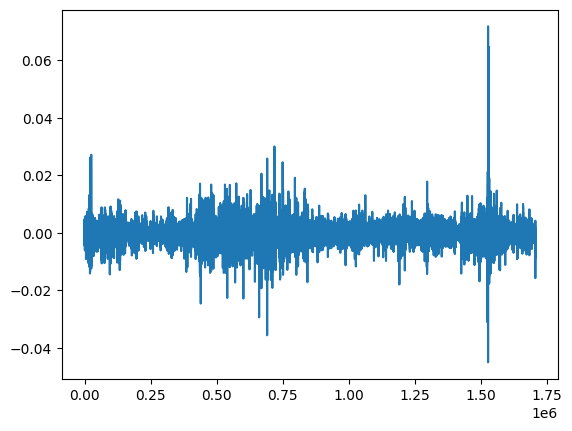

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

n_chunks=5

series_to_test = X['closereturn_L30'].dropna()
series_to_test.plot()

splits = np.array_split(series_to_test.to_numpy(dtype='float32'), n_chunks)

ret = {}
for chunk_id, chunks in enumerate(splits):
    adf_stat, p_value_adf, *_ = adfuller(chunks, autolag='AIC')
    kpss_stat, p_value_kpss, *_ = kpss(chunks, regression='c', nlags='auto')
    ret[chunk_id] = {'adf_stat': adf_stat, 'p_value_adf': p_value_adf, 'kpss_stat': kpss_stat, 'p_value_kpss':p_value_kpss,}



In [34]:
x_col_name = 'return_30'
cutoff = pd.Timestamp('2023-10-12')  # pick your cutoff
mask = X['time'] < cutoff
series_to_test = X.loc[mask, x_col_name]
print(len(series_to_test))
endog = series_to_test
endog.index = X.loc[mask, 'time']

cutoff2 = pd.Timestamp('2024-4-11')  # pick your cutoff
mask = (cutoff <= X['time']) & (X['time'] < cutoff2)
series_to_test = X.loc[mask, x_col_name]
print(len(series_to_test))
endog_val = series_to_test
endog_val.index = X.loc[mask, 'time']

cutoff3 = pd.Timestamp('2024-10-10')  # pick your cutoff
mask = (cutoff2 <= X['time']) & (X['time'] < cutoff3)
series_to_test = X.loc[mask, x_col_name]
print(len(series_to_test))
endog_test = series_to_test
endog_test.index = X.loc[mask, 'time']

1030643
160688
168204


# direct h step ahead forecasting

In [35]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# ---------- 1) Data design: h-spaced lags for a direct-h model ----------
def build_block_lagged(y, lags, h):
    """
    Build design with h-spaced lags: target is y_{t+h},
    regressors are y_{t}, y_{t-h}, y_{t-2h}, ..., y_{t-(lags-1)h}.
    y: pd.Series (time-indexed). lags >= 1, h >= 1
    """
    df = pd.DataFrame({'y': y})
    for i in range(lags):
        df[f'lag_{i}'] = df['y'].shift(i * h)   # i=0 -> y_t, i=1 -> y_{t-h}, ...
    df['target'] = df['y'].shift(-h)            # y_{t+h}
    df = df.dropna()
    X = sm.add_constant(df[[f'lag_{i}' for i in range(lags)]])
    y_target = df['target']
    return X, y_target

def fit_direct_h_ols(y, lags=4, h=3):
    X, target = build_block_lagged(y, lags, h)
    model = sm.OLS(target, X).fit()
    return model, X, target

# ---------- 2) One-step (t+h) prediction with SE from statsmodels ----------
def one_step_pred_with_se(model, x_row):
    """
    x_row: 1x(p+1) design row with constant already added
    Returns mean, mean_se, obs_ci_low, obs_ci_high (95%)
    """
    pr = model.get_prediction(x_row)
    sf = pr.summary_frame(alpha=0.05)
    return (float(sf['mean']),
            float(sf['mean_se']),
            float(sf['obs_ci_lower']),
            float(sf['obs_ci_upper']))

# ---------- 3) Build the latest design row from a vector of h-spaced lags ----------
def latest_design_row(y, lags, h):
    """
    Take the most recent h-spaced lags from y to form X_t.
    Order: const, y_t, y_{t-h}, y_{t-2h}, ...
    """
    vals = [y.iloc[-i*h] for i in range(lags)]  # i=0 -> y_t
    vals = np.array(vals).reshape(1, -1)
    X = sm.add_constant(vals, has_constant='add')
    return X

# ---------- 4A) Delta-method block-recursive t+h then t+2h ----------
def block_recursive_delta_multi(model, y, lags=4, h=3, m=5):
    """
    Perform block-recursive forecasting using the same direct-h OLS model
    up to horizon t + m*h, with analytic delta-method variance propagation.

    This version properly rolls lag values each iteration.
    """
    import numpy as np
    import pandas as pd
    import statsmodels.api as sm

    # Residual variance & coefficients
    sigma2 = model.mse_resid
    beta = model.params.values.reshape(-1, 1)
    Vb = model.cov_params().values

    # Initialize lag values (y_t, y_{t-h}, ..., y_{t-(lags-1)h})
    lag_vals = [y.iloc[-i*h] for i in range(lags)]
    lag_vals = np.array(lag_vals)  # shape (lags,)

    records = []

    # Step 1: initial prediction with full statsmodels API
    X_t = sm.add_constant(lag_vals.reshape(1, -1), has_constant='add')
    pr = model.get_prediction(X_t)
    sf = pr.summary_frame(alpha=0.05)
    mean = float(sf['mean'])
    mean_se = float(sf['mean_se'])
    obs_var = mean_se**2 + sigma2
    ci_low, ci_high = float(sf['obs_ci_lower']), float(sf['obs_ci_upper'])

    records.append({
        'step': 1,
        'horizon': h,
        'mean': mean,
        'mean_se': mean_se,
        'pred_var': obs_var,
        'ci_low': ci_low,
        'ci_high': ci_high
    })

    # Keep track of predictive variance of last y_hat (for propagation)
    var_prev = obs_var

    # Step 2 → m: recursively forecast
    for step in range(2, m + 1):
        # Roll lag values: insert new forecast mean at front, drop oldest
        lag_vals = np.insert(lag_vals[:-1], 0, mean)  # prepend new forecast
        X_next = sm.add_constant(lag_vals.reshape(1, -1), has_constant='add')

        # Mean prediction
        x = X_next.reshape(-1, 1)
        mean = float(x.T @ beta)
        var_mean = float(x.T @ Vb @ x)
        mean_se = np.sqrt(var_mean)

        # Delta method: propagate uncertainty from previous predicted y
        b_lag0 = float(beta[1, 0])
        var_from_input = (b_lag0**2) * var_prev

        # Total predictive variance
        obs_var = var_mean + sigma2 + var_from_input
        ci_low = mean - 1.96 * np.sqrt(obs_var)
        ci_high = mean + 1.96 * np.sqrt(obs_var)

        records.append({
            'step': step,
            'horizon': step * h,
            'mean': mean,
            'mean_se': mean_se,
            'pred_var': obs_var,
            'ci_low': ci_low,
            'ci_high': ci_high
        })

        var_prev = obs_var  # carry forward total predictive variance

    return pd.DataFrame(records).set_index('step')

In [171]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import tqdm

def _build_h_spaced_lags(series, lags, h):
    """Return row vector [y_t, y_{t-h}, ..., y_{t-(lags-1)h}] from the end of `series`."""
    idxs = [-(i*h)-1 for i in range(lags)]
    try:
        vals = np.array([series.iloc[i] for i in idxs], dtype=float).reshape(1, -1)
    except IndexError:
        return None  # not enough history
    return sm.add_constant(vals, has_constant='add')  # prepend constant

def evaluate_walkforward_mse(
    model, train_y, val_y, lags=4, h=3, method="delta", n_sims=5000, seed=7
):
    """
    Walk-forward evaluation for a direct-h OLS model.
    At each validation step k:
      1) Use train_y + val_y[:k] as history to build h-spaced lags at time t0+k
      2) Predict y_{t0+k+h}
      3) Compare to actual val_y[k+h]
    Continues one step at a time across the validation set.

    Returns:
      overall_mse: float
      results_df: DataFrame with columns [t_idx, target_idx, pred, true]
    """
    rng = np.random.default_rng(seed)
    history = train_y.copy()
    preds, trues, t_indices, target_indices = [], [], [], []

    # Precompute for MC if needed
    beta_hat = model.params.values
    Vb = model.cov_params().values
    sigma2 = model.mse_resid

    # We can produce at most len(val_y)-h predictions
    max_k = len(val_y) - h - 1
    for k in tqdm.tqdm(list(range(max_k + 1))):
        # Build h-spaced lags from history up to current t = k (relative to val start)
        X = _build_h_spaced_lags(pd.concat([history, val_y.iloc[[k]]]), lags, h)
        #print(k, X)
        if X is None:
            # Not enough history to form all lags; skip
            # (This shouldn't happen if train_y is long enough)
            # Append the actual current val to history and continue rolling
            history = pd.concat([history, pd.Series([val_y.iloc[k]], index=[val_y.index[k]])])
            continue

        # Predict y_{t+h}
        if method == "delta":
            sf = model.get_prediction(X).summary_frame(alpha=0.05)
            y_pred = float(sf["mean"].iloc[0])
        elif method == "mc":
            # Draw beta and eps, average predictive distribution
            betas = rng.multivariate_normal(beta_hat, Vb, size=n_sims)  # [n_sims, p+1]
            mu = (X @ betas.T).ravel()
            eps = rng.normal(0.0, np.sqrt(sigma2), size=n_sims)
            y_pred = float(np.mean(mu + eps))
        else:
            raise ValueError("method must be 'delta' or 'mc'")

        # Ground truth at t+h (within validation window)
        true_y = val_y.iloc[k + h]

        preds.append(y_pred)
        trues.append(true_y)
        t_indices.append(val_y.index[k])           # time we forecast FROM
        target_indices.append(val_y.index[k + h])  # time we forecast FOR

        # Reveal the actual current observation and roll forward by 1
        history = pd.concat([history, pd.Series([val_y.iloc[k]], index=[val_y.index[k]])])

    overall_mse = mean_squared_error(trues, preds)
    results_df = pd.DataFrame({
        "t_idx": t_indices,
        "target_idx": target_indices,
        "pred": preds,
        "true": trues,
        "sq_err": (np.array(trues) - np.array(preds))**2
    })

    return overall_mse, results_df


In [172]:
# Fit direct-h OLS
model, X, target = fit_direct_h_ols(endog[-50000:], lags=10, h=30)
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     34.76
Date:                Sat, 01 Nov 2025   Prob (F-statistic):           2.27e-68
Time:                        22:10:48   Log-Likelihood:             2.6309e+05
No. Observations:               49700   AIC:                        -5.262e+05
Df Residuals:                   49689   BIC:                        -5.261e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.192e-06   5.45e-06      0.585      0.5

In [173]:
# Walk-forward, one step at a time, predicting t+h each time
mse, df = evaluate_walkforward_mse(
    model, endog, endog_val[:2000], lags=10, h=30, method="delta"  # or method="mc"
)

100%|██████████| 1970/1970 [00:24<00:00, 80.10it/s] 


In [134]:
df

,t_idx,target_idx,pred,true,sq_err
0,2023-10-12 00:00:00,2023-10-12 00:15:00,0.000082,0.000159,5.987561e-09
1,2023-10-12 00:01:00,2023-10-12 00:16:00,-0.000032,0.000182,4.588416e-08
2,2023-10-12 00:02:00,2023-10-12 00:17:00,-0.000185,0.000273,2.097912e-07
3,2023-10-12 00:03:00,2023-10-12 00:18:00,-0.000154,0.000182,1.130496e-07
4,2023-10-12 00:04:00,2023-10-12 00:19:00,-0.000078,0.000000,6.049057e-09
...,...,...,...,...,...
180,2023-10-12 03:05:00,2023-10-12 03:22:00,0.000043,0.000182,1.938509e-08
181,2023-10-12 03:06:00,2023-10-12 03:23:00,0.000111,0.000296,3.409618e-08
182,2023-10-12 03:07:00,2023-10-12 03:24:00,0.000135,0.000182,2.255739e-09
183,2023-10-12 03:08:00,2023-10-12 03:25:00,0.000157,0.000296,1.927829e-08


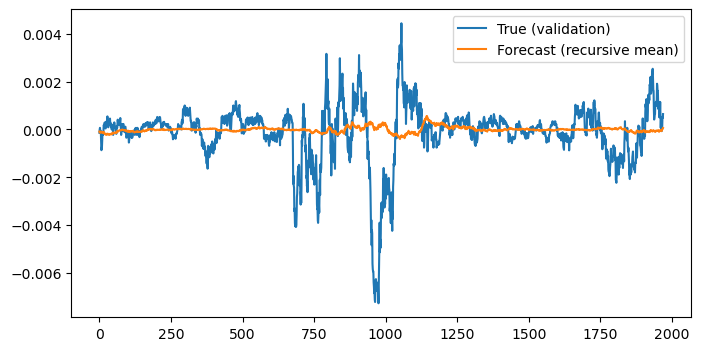

In [174]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(df["true"].values, label="True (validation)")
plt.plot(df["pred"].values, label="Forecast (recursive mean)")
plt.legend()
plt.show()

# indirect forecasting

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import os, pickle, json


# === 1-step recursive forecast (FAST) =======================================
def recursive_forecast_t_plus_h_fast(model, history_arr, lags, horizon=30):
    """
    Use a 1-step model to recursively forecast horizon steps ahead.
    Vectorized, no pandas operations inside loop.
    history_arr : np.ndarray, shape (>=lags,)
    Returns:
      y_pred_h : float, forecast at t+h
      preds : list of all intermediate forecasts
    """
    beta = model.params.values      # includes intercept
    const = beta[0]
    coef = beta[1:]
    preds = []

    # rolling buffer of last `lags` observations
    buf = np.array(history_arr[-lags:], dtype=float)

    for _ in range(horizon):
        # y_pred = const + dot(lag_vector, coef)
        y_pred = const + np.dot(buf[::-1], coef)
        preds.append(y_pred)
        # roll buffer: drop oldest, append new forecast
        buf[:-1] = buf[1:]
        buf[-1] = y_pred

    return preds[-1], preds


# === Validation evaluation (indirect, fast) =================================
def evaluate_indirect_mse_fast(model, train_y, val_y, lags=4, horizon=30):
    """
    Evaluate t+h recursive forecasts from a 1-step model.
    Vectorized & optimized version.
    """
    y_train = np.asarray(train_y, dtype=float)
    y_val = np.asarray(val_y, dtype=float)

    preds, trues, t_idx, target_idx = [], [], [], []
    n_val = len(y_val)
    max_k = n_val - horizon

    # Preallocate for speed
    for k in tqdm.tqdm(list(range(max_k))):
        # combine training + known validation up to current k
        history_arr = np.concatenate([y_train, y_val[:k]])
        if len(history_arr) < lags:
            continue

        y_pred_h, _ = recursive_forecast_t_plus_h_fast(
            model, history_arr, lags, horizon=horizon
        )

        true_y = y_val[k + horizon]
        preds.append(y_pred_h)
        trues.append(true_y)
        t_idx.append(k)
        target_idx.append(k + horizon)

    mse = mean_squared_error(trues, preds)
    df = pd.DataFrame({
        "t_idx": t_idx,
        "target_idx": target_idx,
        f"pred_t+{horizon}": preds,
        f"true_t+{horizon}": trues
    })
    return mse, df

def train_val_h_step_OLS(endog_train, endog_val, lags, expt_dir, h=30):
    # Train 1-step OLS model
    model_1step, _, _ = fit_direct_h_ols(endog_train, lags=lags, h=h)
    # Evaluate indirect t+30 performance (fast)
    mse_30, result_df = evaluate_indirect_mse_fast(
        model_1step, endog_train, endog_val, lags=lags, horizon=h
    )

    # Create timestamped subdirectory
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    save_dir = os.path.join(expt_dir, f"{lags}_{timestamp}")
    os.makedirs(save_dir, exist_ok=True)

    # Save model
    model_path = os.path.join(save_dir, "model.pkl")
    with open(model_path, "wb") as f:
        pickle.dump(model, f)

    # Save results dataframe
    csv_path = os.path.join(save_dir, "forecast_results.csv")
    result_df.to_csv(csv_path, index=False)

    # Load existing data if present
    json_path = os.path.join(save_dir, "AR_results.json")
    if os.path.exists(json_path):
        with open(json_path, "r") as f:
            try:
                metrics_dict = json.load(f)
            except json.JSONDecodeError:
                metrics_dict = {}
    else:
        metrics_dict = {}

    metrics_dict[lags] = mse_30

    with open(json_path, "w") as f:
        json.dump(metrics_dict, f, indent=4)



In [ ]:
train_val_h_step_OLS(endog, endog_val, 1, './AR_tuning', h=30)
train_val_h_step_OLS(endog, endog_val, 2, './AR_tuning', h=30)
train_val_h_step_OLS(endog, endog_val, 3, './AR_tuning', h=30)

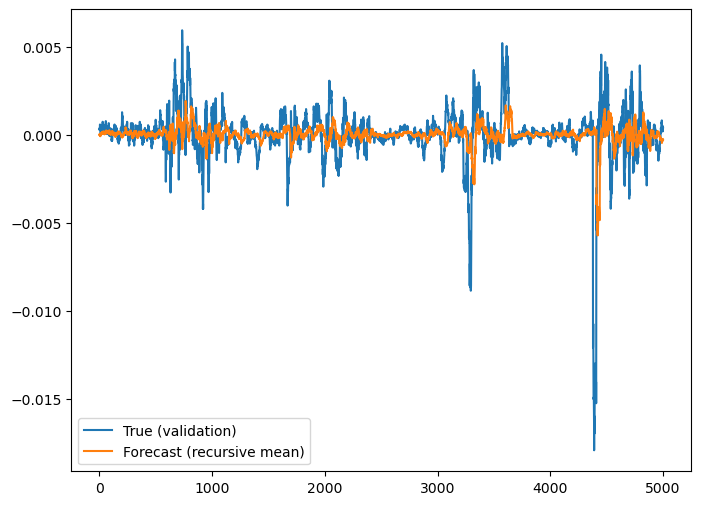

In [200]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(result_df["true_t+30"].values[-5000:], label="True (validation)")
plt.plot(result_df["pred_t+30"].values[-5000:], label="Forecast (recursive mean)")
plt.legend()
plt.show()

c:\Users\user\anaconda3\envs\kz2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\user\anaconda3\envs\kz2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              return_30   No. Observations:                  500
Model:               SARIMAX(2, 0, 0)   Log Likelihood                3234.348
Date:                Sat, 01 Nov 2025   AIC                          -6460.696
Time:                        01:59:32   BIC                          -6443.838
Sample:                             0   HQIC                         -6454.081
                                - 500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   6.378e-06   1.66e-05      0.385      0.700   -2.61e-05    3.88e-05
ar.L1          0.9037      0.044     20.330      0.000       0.817       0.991
ar.L2          0.0621      0.044      1.403      0.1

c:\Users\user\anaconda3\envs\kz2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\user\anaconda3\envs\kz2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


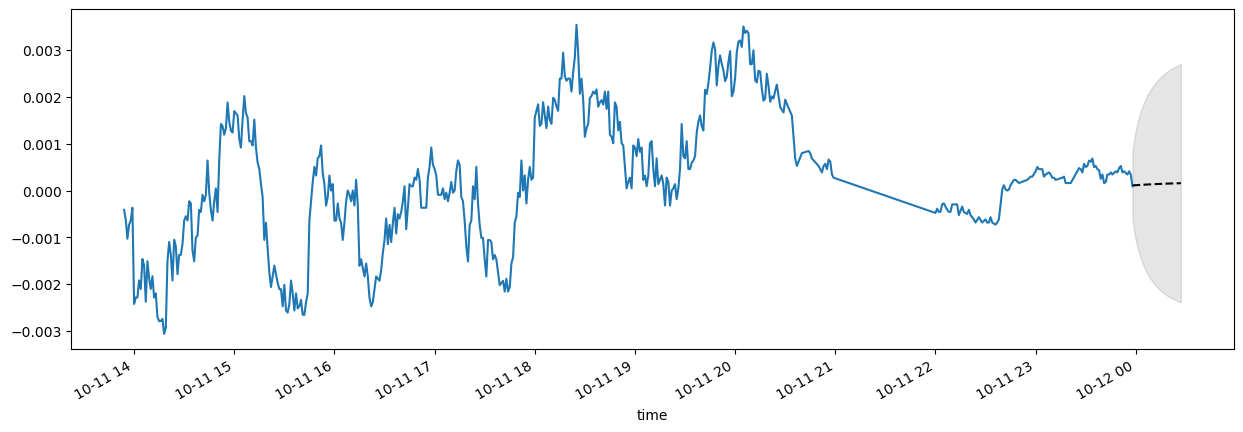

In [84]:
import statsmodels.api as sm
import pickle
h=30
mod = sm.tsa.SARIMAX(endog[-500:], order=(2, 0, 0), trend="c")
res = mod.fit()

print(res.summary())

# Save the model to a file
with open('./ARIMA_2_0_0.pkl', 'wb') as f:
    pickle.dump(res, f)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
endog[-500:].plot(ax=ax)

# Construct the forecasts
fcast = res.get_forecast(steps=h).summary_frame()
last_timestamp = endog.index[-1]
future_index = pd.date_range(last_timestamp, periods=h, freq='min')
fcast.index = future_index

fcast["mean"].plot(ax=ax, style="k--")
ax.fill_between(
    fcast.index, fcast["mean_ci_lower"], fcast["mean_ci_upper"], color="k", alpha=0.1
)

In [145]:
import tqdm
def run_h_step_forecast(res, endog, h=30):
    forecasts = []
    for i in tqdm.tqdm(list(range(len(endog)))):
        res = res.append([endog.iloc[i:i+1].item()], refit=False)
        forecasts.append(res.forecast(steps=h).iloc[-1])
        #forecasts.append(res.get_forecast(steps=h).summary_frame().iloc[-1,:])
    return pd.DataFrame(forecasts)

In [85]:
# Load the model from the file
with open('./ARIMA_2_0_0.pkl', 'rb') as f:
    loaded_model = pickle.load(f)
loaded_model.model.data.orig_endog.index[-1]

Timestamp('2023-10-11 23:58:00')

In [139]:
loaded_model.forecast(steps=30).iloc[-1]

c:\Users\user\anaconda3\envs\kz2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\user\anaconda3\envs\kz2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


0.000156619954445683

In [146]:
results_val = run_h_step_forecast(loaded_model, endog_val,h=30)

  0%|          | 0/160688 [00:00<?, ?it/s]c:\Users\user\anaconda3\envs\kz2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\user\anaconda3\envs\kz2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\user\anaconda3\envs\kz2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
 84%|████████▎ | 134472/160688 [7:56:55<1:32:58,  4.70it/s]


KeyboardInterrupt: 

In [ ]:
from pmdarima import auto_arima
model = auto_arima(
    endog,
    start_p=0,
    start_q=0,
    max_p=3,
    max_q=3,
    d=0,            # let the function difference as needed (ADF-based)
    seasonal=False,    # True + m>1 for seasonal data
    trace=True,
    stepwise=True,
    suppress_warnings=True,
    error_action="raise",
    with_intercept=True
)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-9780661.978, Time=51.56 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-12429907.760, Time=71.93 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-10430615.466, Time=111.47 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-9780640.871, Time=17.23 sec


# Merging market and news

In [152]:
# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

In [170]:
def merge_market_news(
    market_df: pd.DataFrame,
    news_df: Optional[pd.DataFrame],
    tolerance_hours: int = 6
) -> pd.DataFrame:
    """Left-join market data with news signals, forward-filling missing news values."""
    market_sorted = market_df.sort_values('time').reset_index(drop=True).copy()
    market_sorted['time'] = pd.to_datetime(market_sorted['time'])

    if news_df is None or news_df.empty:
        logger.info("No news data - using market features only")
        market_sorted['news_rows_since_update'] = pd.NA
        market_sorted['news_available'] = 0
        market_sorted['news_age_minutes'] = np.nan
        return market_sorted

    logger.info(f"Merging market features with news signals. Market Feature Initial Shape: {market_sorted.shape}")

    news_sorted = news_df.sort_values('signal_time').reset_index(drop=True).copy()
    news_sorted['signal_time'] = pd.to_datetime(news_sorted['signal_time'])

    news_value_cols = [col for col in news_sorted.columns if col != 'signal_time']
    rename_map = {'signal_time': 'news_signal_time', **{col: f'news_{col}' for col in news_value_cols}}
    news_prefixed = news_sorted.rename(columns=rename_map)

    merge_kwargs = {
        "left_on": "time",
        "right_on": "news_signal_time",
        "direction": "backward",
    }
    if tolerance_hours is not None:
        merge_kwargs["tolerance"] = pd.Timedelta(hours=tolerance_hours)

    combined_df = pd.merge_asof(market_sorted, news_prefixed, **merge_kwargs)

    news_time = combined_df['news_signal_time']
    is_new_news = news_time.notna() & news_time.ne(news_time.shift())
    event_id = is_new_news.cumsum()
    rows_since = combined_df.groupby(event_id).cumcount().astype('Int64')
    rows_since = rows_since.where(event_id > 0, pd.NA)

    news_cols_to_ffill = [col for col in combined_df.columns if col.startswith('news_')]
    if news_cols_to_ffill:
        combined_df[news_cols_to_ffill] = combined_df[news_cols_to_ffill].ffill()

    combined_df['news_rows_since_update'] = rows_since
    combined_df['news_available'] = combined_df['news_signal_time'].notna().astype(int)

    if 'news_signal_time' in combined_df.columns:
        combined_df['news_signal_time'] = pd.to_datetime(combined_df['news_signal_time'])
        combined_df['news_age_minutes'] = (
            combined_df['time'] - combined_df['news_signal_time']
        ).dt.total_seconds() / 60

    logger.info(f"Merged dataset shape: {combined_df.shape}")
    news_coverage = combined_df['news_available'].mean()
    fresh_news = (combined_df['news_rows_since_update']==0).mean()
    logger.info(f"News coverage: {news_coverage:.1%}. Fresh news fraction: {fresh_news:.1%}")
    labels = combined_df[['time', 'instrument' ,'return_30']].copy()
    labels['return_30'] = labels['return_30'].shift(30)


    return combined_df, labels



In [171]:
combined_df, labels = merge_market_news(Xraw, Xnews)

2025-11-01 12:40:18,580 - INFO - Merging market features with news signals. Market Feature Initial Shape: (1705216, 68)
2025-11-01 12:40:19,866 - INFO - Merged dataset shape: (1705216, 82)
2025-11-01 12:40:19,924 - INFO - News coverage: 99.7%. Fresh news fraction: 0.7%


In [172]:
combined_df.to_csv('./combined_data.csv')

In [176]:
pd.date_range(start='1/1/2021', end='3/31/2021', freq='1T')

C:\Users\user\AppData\Local\Temp\ipykernel_29284\522246502.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  pd.date_range(start='1/1/2021', end='3/31/2021', freq='1T')


DatetimeIndex(['2021-01-01 00:00:00', '2021-01-01 00:01:00',
               '2021-01-01 00:02:00', '2021-01-01 00:03:00',
               '2021-01-01 00:04:00', '2021-01-01 00:05:00',
               '2021-01-01 00:06:00', '2021-01-01 00:07:00',
               '2021-01-01 00:08:00', '2021-01-01 00:09:00',
               ...
               '2021-03-30 23:51:00', '2021-03-30 23:52:00',
               '2021-03-30 23:53:00', '2021-03-30 23:54:00',
               '2021-03-30 23:55:00', '2021-03-30 23:56:00',
               '2021-03-30 23:57:00', '2021-03-30 23:58:00',
               '2021-03-30 23:59:00', '2021-03-31 00:00:00'],
              dtype='datetime64[ns]', length=128161, freq='min')

In [1]:
import sys
from pathlib import Path

project_root = Path.cwd().resolve()
if project_root.name == "notebooks":          # notebook opened from ./notebooks
    project_root = project_root.parent

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from src_clean.data_pipelines.silver.market_volatility_processor import VolatilityProcessor

In [2]:
vp = VolatilityProcessor(input_path='../data_clean/bronze/market/spx500_usd_m1_5years.ndjson', output_path='./test', window=20)

In [3]:
df = vp.load_candles()

2025-11-01 13:37:51,622 - INFO - Loading candles from ../data_clean/bronze/market/spx500_usd_m1_5years.ndjson
C:\Users\user\Desktop\kz code\fx-ml-pipeline\src_clean\data_pipelines\silver\market_volatility_processor.py:68: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_index = pd.date_range(
2025-11-01 13:38:01,595 - INFO - Reindex completed. Adding gap metadata.
2025-11-01 13:38:03,155 - INFO - Loaded 2625455 candles after filling gaps (original: 1705276). Percentage of backfill: 35.0%. Percentage of orig 30-60min: 68.8%. Percentage of 30-360min: 73.4%


In [5]:
df.iloc[:200000,:].to_csv('./test.csv')

In [4]:
df.tail()

,time,instrument,granularity,open,high,low,close,volume,collected_at,minutes_since_last_data,is_backfilled,has_original_prev_30_to_60min,has_original_prev_30_to_360min
2625450,2025-10-10 20:55:00+00:00,SPX500_USD,M1,6515.0,6517.0,6503.6,6513.6,555.0,2025-10-12T15:30:07.014647Z,0,0,1,1
2625451,2025-10-10 20:56:00+00:00,SPX500_USD,M1,6513.6,6518.6,6512.2,6516.0,416.0,2025-10-12T15:30:07.014653Z,0,0,1,1
2625452,2025-10-10 20:57:00+00:00,SPX500_USD,M1,6516.0,6525.2,6511.6,6514.4,501.0,2025-10-12T15:30:07.014659Z,0,0,1,1
2625453,2025-10-10 20:58:00+00:00,SPX500_USD,M1,6513.8,6515.6,6511.2,6512.6,348.0,2025-10-12T15:30:07.014665Z,0,0,1,1
2625454,2025-10-10 20:59:00+00:00,SPX500_USD,M1,6512.4,6513.8,6512.2,6512.6,36.0,2025-10-12T15:30:07.014670Z,0,0,1,1
